## 5 - Benchmarking

### Benchmarking Model - TensorFlow Algorith

In this notebook we are going to perform our inference on our benchmark model. The following code has been adapted from this [script](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/object_detection_tensorflow/Amazon_Tensorflow_Object_Detection.ipynb) in order to inference and get predictions from our validation dataset.

The SSD ResNet50 V1 FPN 640x640, often referred to as RetinaNet50, is an object detection model optimized for both speed and accuracy. It combines the power of the ResNet50 architecture, known for its deep residual layers and robust feature extraction, with the Single Shot MultiBox Detector (SSD) methodology for fast object detection. Pre-trained on the [COCO 2017 dataset](https://cocodataset.org/#home), this model is capable of detecting a wide range of object classes with impressive precision. Airplanes is one of them, so we will use this model to benchmark.

More infor about TensorFlow algorithm and models in SageMaker can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection-tensorflow.html).

In [23]:
import sagemaker, boto3, json
from sagemaker.session import Session
import IPython
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models
from sagemaker.jumpstart.filters import And, Or

from sagemaker import image_uris, model_uris, script_uris
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

import matplotlib.patches as patches
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageColor
import numpy as np
import glob
import pandas as pd
import json
import matplotlib.pyplot as plt

In [3]:
sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### Retrieve Artifacts

In [4]:
# model_version="*" fetches the latest version of the model.
model_id, model_version = "tensorflow-od1-ssd-resnet50-v1-fpn-640x640-coco17-tpu-8", "*"


infer_model_id, infer_model_version = model_id, model_version

endpoint_name = name_from_base(f"mouse-inference-benchmarking-{infer_model_id}")

inference_instance_type = "ml.p2.xlarge"



# Retrieve the inference docker container uri.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=infer_model_id,
    model_version=infer_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri.
deploy_source_uri = script_uris.retrieve(
    model_id=infer_model_id, model_version=infer_model_version, script_scope="inference"
)
# Retrieve the base model uri.
base_model_uri = model_uris.retrieve(
    model_id=infer_model_id, model_version=infer_model_version, model_scope="inference"
)
# Create the SageMaker model instance. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=base_model_uri,
    entry_point="inference.py",
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


#### Deploy the Model

In [ ]:
base_model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    endpoint_name=endpoint_name,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
------------------!

#### Functions

We will define first all the funcions we need in order to perform the inference

In [6]:
def query(model_predictor, image_file_name):
    with open(image_file_name, "rb") as file:
        input_img_rb = file.read()

    query_response = model_predictor.predict(
        input_img_rb,
        {
            "ContentType": "application/x-image",
            "Accept": "application/json;verbose;n_predictions=1",
        },
    )
    return query_response

def parse_response(query_response):
    model_predictions = json.loads(query_response)
    normalized_boxes, classes, scores, labels = (
        model_predictions["normalized_boxes"],
        model_predictions["classes"],
        model_predictions["scores"],
        model_predictions["labels"],
    )

    class_names = [labels[int(idx)] for idx in classes]
    

    indices = [i for i, name in enumerate(class_names) if name == "airplane"]
    normalized_boxes = [normalized_boxes[i] for i in indices]
    class_names = [class_names[i] for i in indices]
    scores = [scores[i] for i in indices]
    
    return normalized_boxes, class_names, scores

def display_predictions(img_jpg, normalized_boxes, classes_names, confidences):
    
    colors = list(ImageColor.colormap.values())
    image_np = np.array(Image.open(img_jpg))
    plt.figure(figsize=(20, 20))
    ax = plt.axes()
    ax.imshow(image_np)

    for idx in range(len(normalized_boxes)):
        left, bot, right, top = normalized_boxes[idx]
        x, w = [val * image_np.shape[1] for val in [left, right - left]]
        y, h = [val * image_np.shape[0] for val in [bot, top - bot]]
        color = colors[hash(classes_names[idx]) % len(colors)]
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        ax.text(
            x,
            y,
            "{} {:.0f}%".format(classes_names[idx], confidences[idx] * 100),
            bbox=dict(facecolor="white", alpha=0.5),
        )

def filter_predictions_for_class(normalized_boxes, classes_names, confidences, target_class="airplane"):
    
    indices = [i for i, class_name in enumerate(classes_names) if class_name == target_class]
    normalized_boxes = [normalized_boxes[i] for i in indices]
    classes_names = [classes_names[i] for i in indices]
    confidences = [confidences[i] for i in indices]
    return normalized_boxes, classes_names, confidences

#### Testing Endpoint with 4 images

In [7]:
img_1 = "airplane_detection/images/airplanes/images/validation/0001eeaf4aed83f9.jpg"
img_2 = "airplane_detection/images/airplanes/images/validation/0009bad4d8539bb4.jpg"
img_3 = "airplane_detection/images/airplanes/images/validation/0019e544c79847f5.jpg"
img_4 = "airplane_detection/images/airplanes/images/validation/007384da2ed0464f.jpg"

images_test = [img_1, img_2, img_3, img_4]

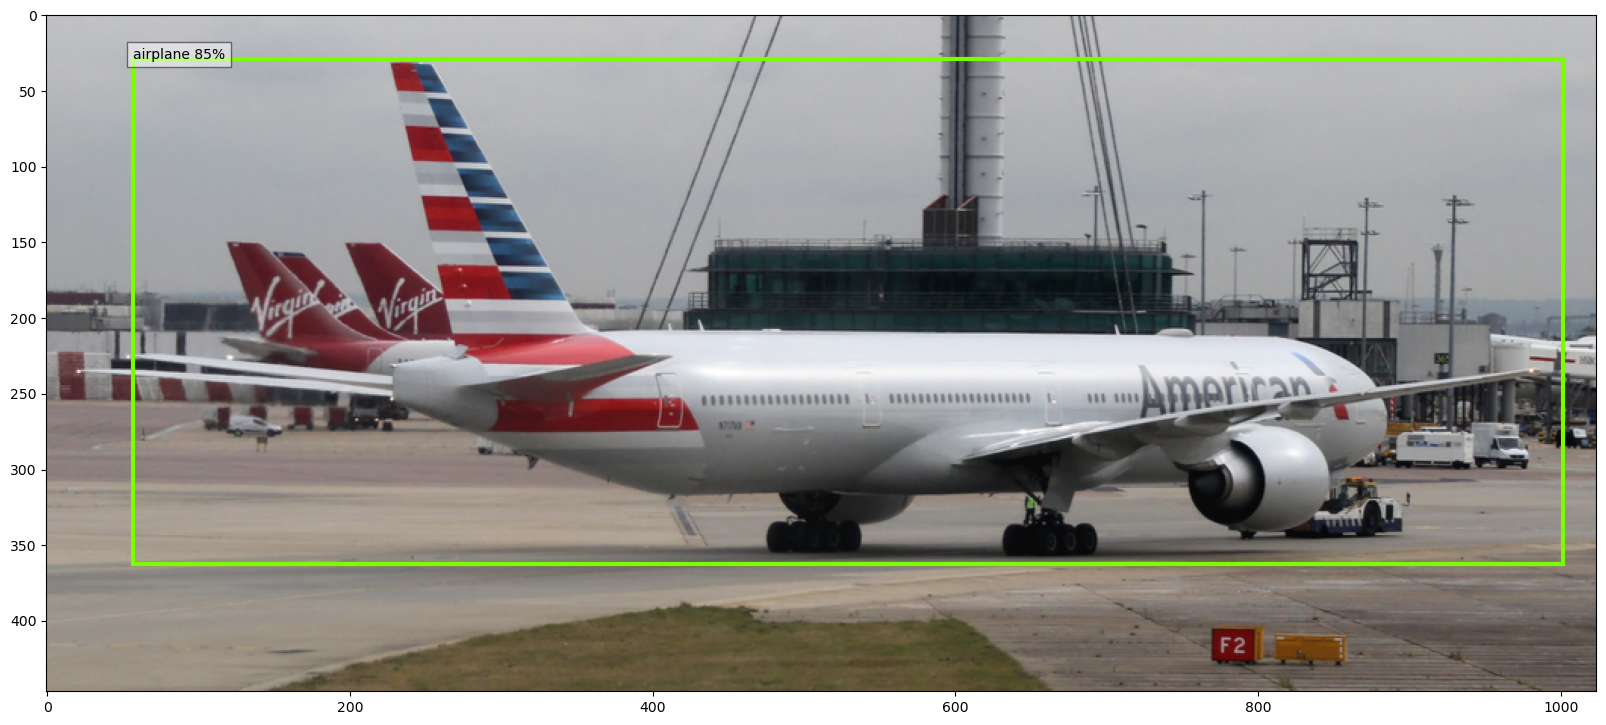

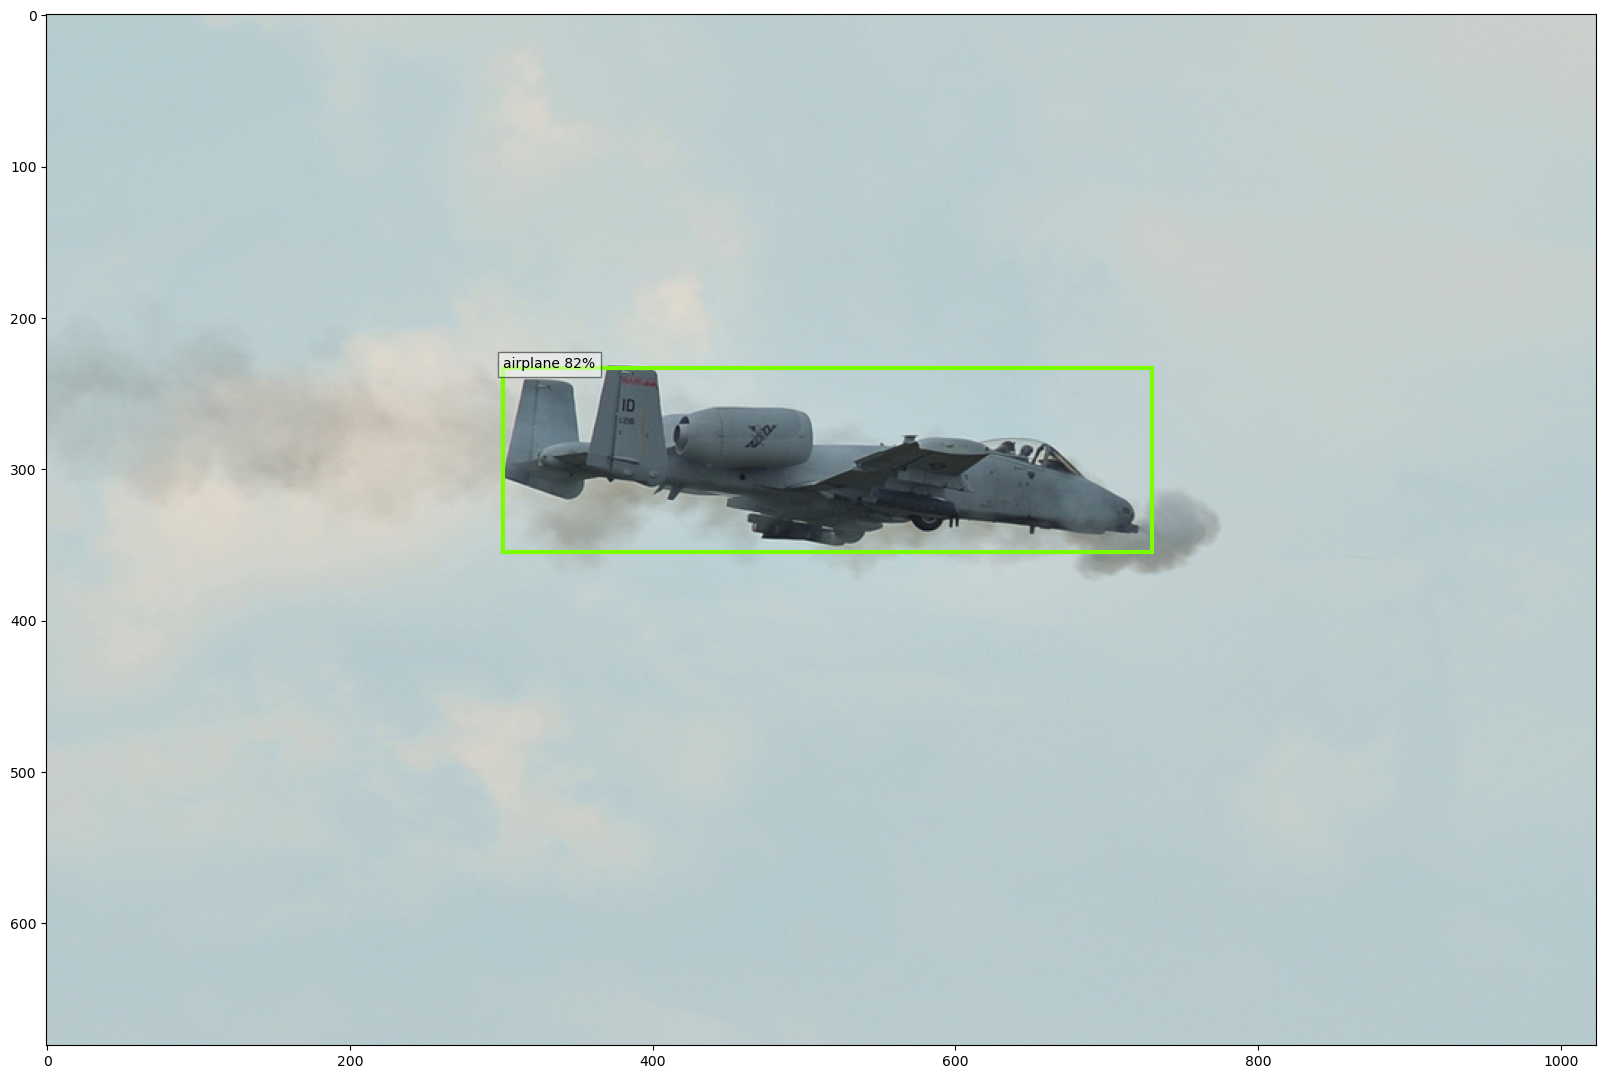

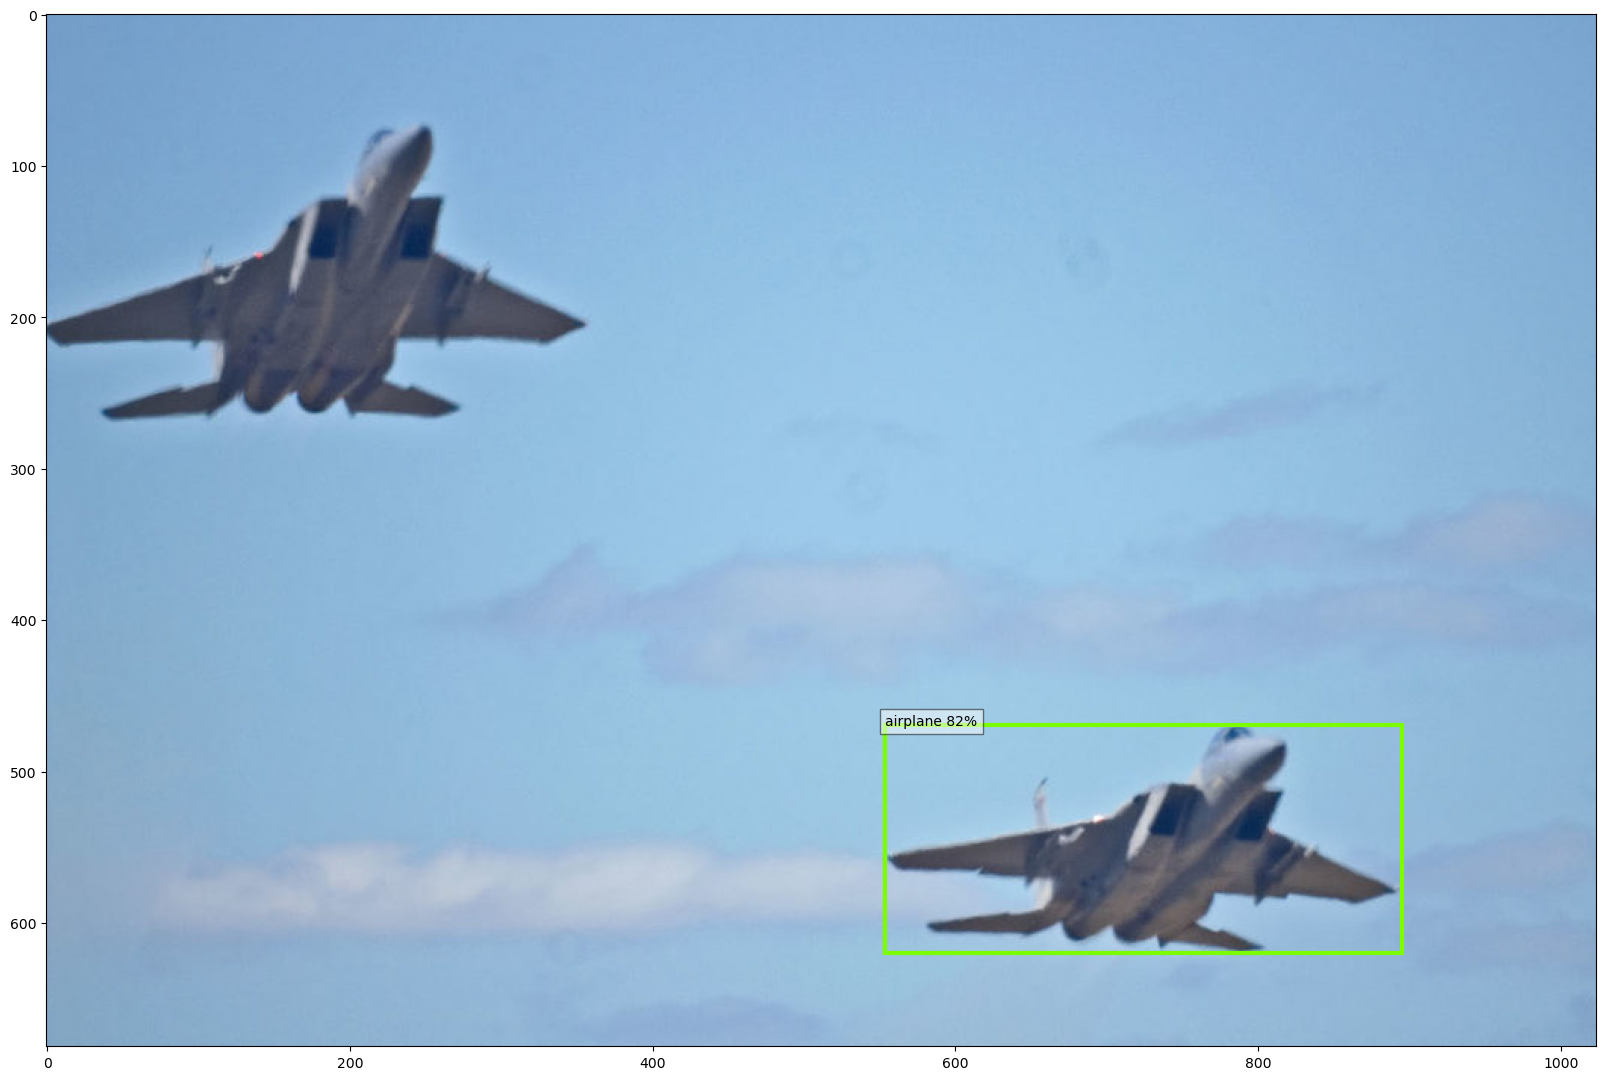

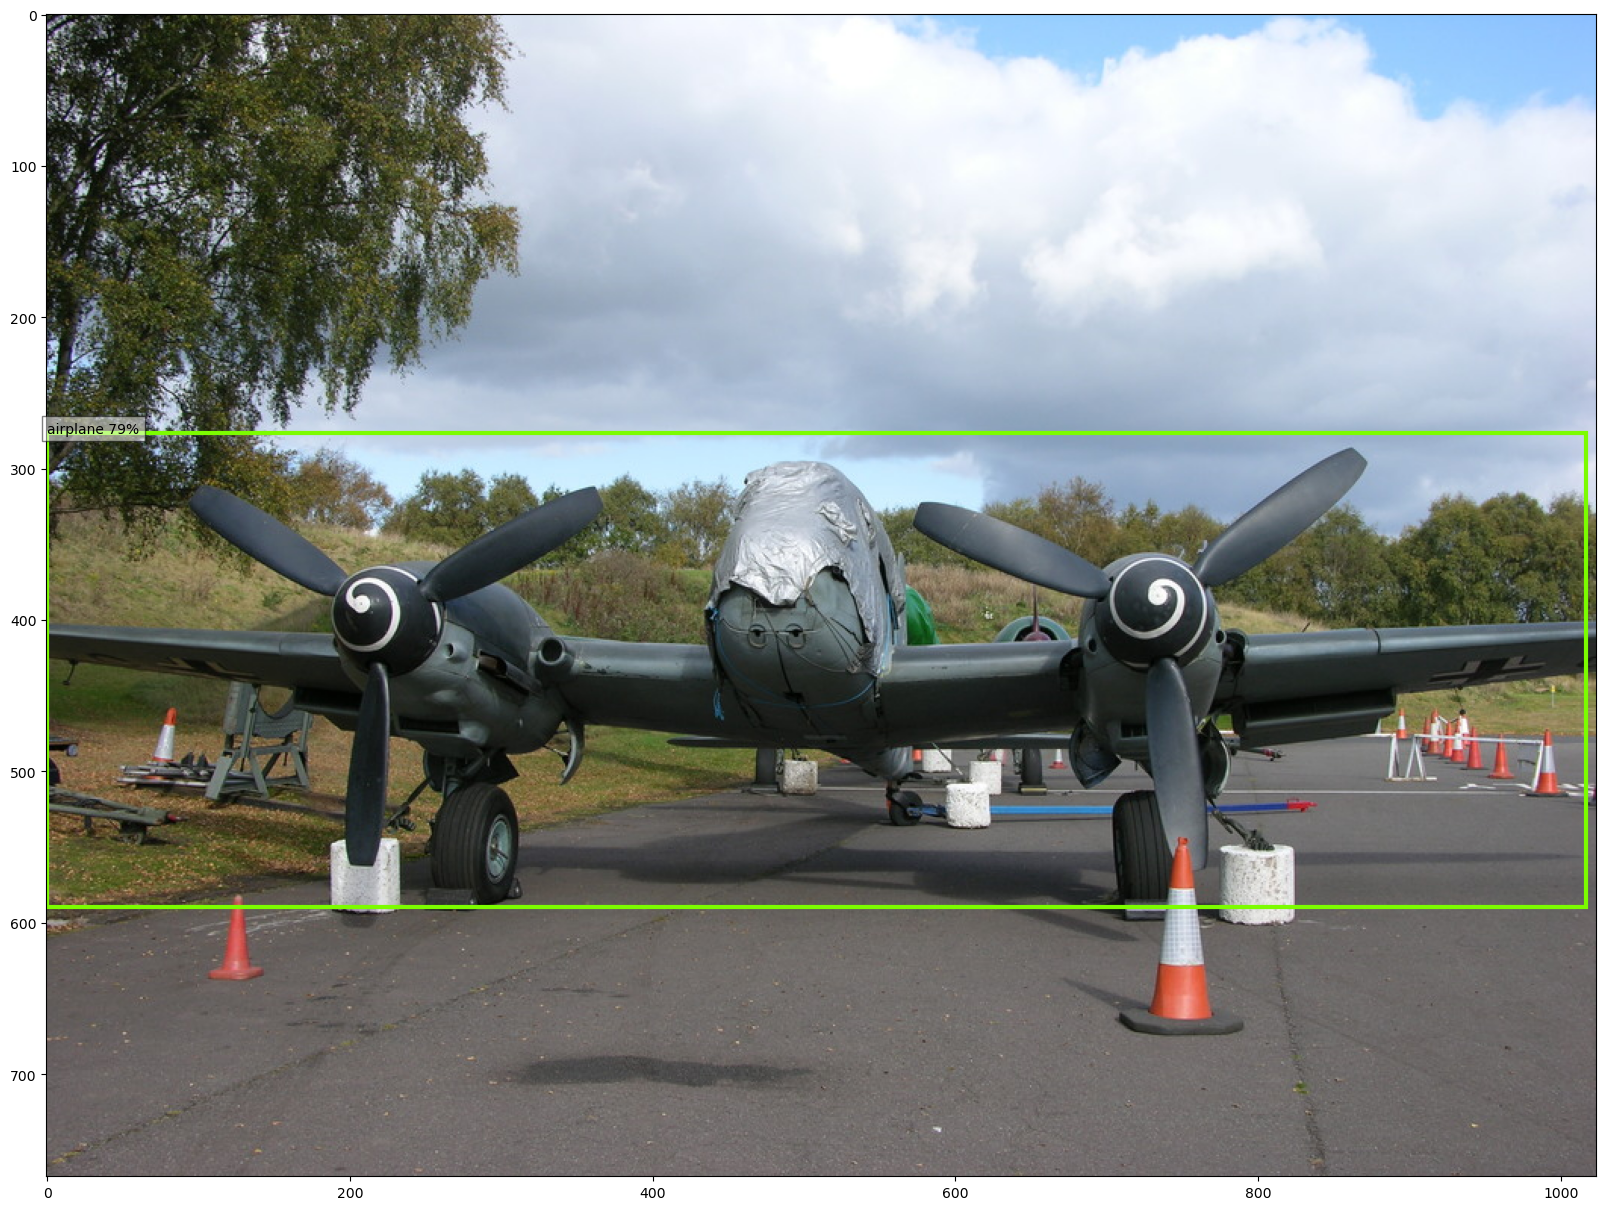

In [8]:
for test_image in images_test:
    query_response = query(base_model_predictor, test_image)
    normalized_boxes, classes_names, confidences = parse_response(query_response)


    indices = [i for i, class_name in enumerate(classes_names) if class_name == "airplane"]
    normalized_boxes = [normalized_boxes[i] for i in indices]
    classes_names = [classes_names[i] for i in indices]
    confidences = [confidences[i] for i in indices]


    display_predictions(test_image, normalized_boxes, classes_names, confidences)

### Perform Inference and get the metrics

In [26]:
# Path to the images
image_paths = glob.glob('airplane_detection/images/airplanes/images/validation/*.jpg')
len(image_paths)

250

In [27]:
# Functions to get all bounding boxes based on the threshold and save them as a Dataframe

def query(model_predictor, image_file_name):
    with open(image_file_name, "rb") as file:
        input_img_rb = file.read()

    query_response = model_predictor.predict(
        input_img_rb,
        {
            "ContentType": "application/x-image",
            "Accept": "application/json;verbose",
        },
    )
    return query_response

def parse_response(query_response):
    model_predictions = json.loads(query_response)
    normalized_boxes, classes, scores, labels = (
        model_predictions["normalized_boxes"],
        model_predictions["classes"],
        model_predictions["scores"],
        model_predictions["labels"],
    )
    class_names = [labels[int(idx)] for idx in classes]
    return normalized_boxes, class_names, scores

def display_predictions(img_jpg, normalized_boxes, classes_names, confidences):
    colors = list(ImageColor.colormap.values())
    image_np = np.array(Image.open(img_jpg))
    plt.figure(figsize=(20, 20))
    ax = plt.axes()
    ax.imshow(image_np)
    for idx in range(len(normalized_boxes)):
        left, bot, right, top = normalized_boxes[idx]
        x, w = [val * image_np.shape[1] for val in [left, right - left]]
        y, h = [val * image_np.shape[0] for val in [bot, top - bot]]
        color = colors[hash(classes_names[idx]) % len(colors)]
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        ax.text(
            x,
            y,
            "{} {:.0f}%".format(classes_names[idx], confidences[idx] * 100),
            bbox=dict(facecolor="white", alpha=0.5),
        )


results = []


for image_path in image_paths:
    query_response = query(base_model_predictor, image_path)
    normalized_boxes, classes_names, confidences = parse_response(query_response)
    
    valid_indices = [i for i, (class_name, confidence) in enumerate(zip(classes_names, confidences)) 
                     if class_name == "airplane"]
    
    for i in valid_indices:
        result = {
            'image_path': image_path,
            'normalized_boxes': normalized_boxes[i],
            'classes_names': classes_names[i],
            'confidences': confidences[i]
        }
        results.append(result)

# Save the results as a dataframe
df_results = pd.DataFrame(results)


In [29]:
df_results.head()

image_path  \
0  airplane_detection/images/airplanes/images/val...   
1  airplane_detection/images/airplanes/images/val...   
2  airplane_detection/images/airplanes/images/val...   
3  airplane_detection/images/airplanes/images/val...   
4  airplane_detection/images/airplanes/images/val...   

                                    normalized_boxes classes_names  \
0  [0.195158422, 0.370840847, 0.961155593, 0.6590...      airplane   
1   [0.00636041164, 0.00251412392, 1.0, 0.992112875]      airplane   
2  [0.243865579, 0.331120282, 0.793745399, 0.5301...      airplane   
3  [0.000510841608, 0.0482648611, 0.988637, 0.980...      airplane   
4                [0.0, 0.128350705, 1.0, 0.67401588]      airplane   

   confidences  
0     0.825679  
1     0.654442  
2     0.678474  
3     0.692324  
4     0.755972

In [30]:
df_results.to_csv('data/benchmarking_results/tensorflow_benchmarking_results_v2.csv', index=False)

Once we performed our inference on our benchmark model, we can turn off the endpoint created:

In [31]:
base_model_predictor.delete_model()
base_model_predictor.delete_endpoint()